# NumPy API Evolution Analysis using PyPevol

This notebook analyzes NumPy's API evolution using the PyPevol high-level APIs. We'll leverage PyPevol's powerful analysis capabilities to:

1. **Fetch NumPy versions** from PyPI automatically
2. **Analyze API changes** across versions using PyPevol's built-in analyzer
3. **Generate insights and visualizations** about API evolution patterns
4. **Export comprehensive reports** in multiple formats

**Key Advantages of Using PyPevol:**
- ✅ **Automated PyPI integration** - No manual repository cloning needed
- ✅ **Built-in API parsing** - Leverages sophisticated AST analysis
- ✅ **Change detection** - Automatically identifies added, removed, and modified APIs
- ✅ **Professional reporting** - Rich data structures and export capabilities

## 1. Import Required Libraries and Setup PyPevol

We'll import PyPevol and set up the analysis environment with all necessary dependencies.

In [1]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from collections import Counter
import warnings
from tqdm.notebook import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Import PyPevol modules
try:
    import pypevol
    from pypevol.analyzer import PackageAnalyzer
    from pypevol.reports import ReportGenerator
    from pypevol.models import APIType, ChangeType
    print("✅ All required libraries imported successfully!")
    print(f"PyPevol version: {pypevol.__version__}")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure PyPevol is installed: pip install pypevol")
    sys.exit(1)

✅ All required libraries imported successfully!
PyPevol version: 0.1.0


/home/ec2-user/miniconda3/envs/pymevol/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 2. Configure PyPevol Analyzer

Set up the PyPevol PackageAnalyzer with optimized settings for NumPy analysis.

In [2]:
# Configuration for NumPy analysis
PACKAGE_NAME = "numpy"
ANALYSIS_DIR = Path("/home/ec2-user/numpy_analysis")
CACHE_DIR = ANALYSIS_DIR / "cache"

# Create analysis directories
ANALYSIS_DIR.mkdir(exist_ok=True)
CACHE_DIR.mkdir(exist_ok=True)

# Analysis parameters
from_date = datetime(2024, 1, 1)  # Start from 2023 for comprehensive analysis
to_date = datetime.now()
max_versions = 20  # Limit for performance - can be increased for full analysis

print(f"📦 Package: {PACKAGE_NAME}")
print(f"📅 Analysis period: {from_date.strftime('%Y-%m-%d')} to {to_date.strftime('%Y-%m-%d')}")
print(f"📁 Analysis directory: {ANALYSIS_DIR}")
print(f"💾 Cache directory: {CACHE_DIR}")
print(f"🔢 Maximum versions to analyze: {max_versions}")

# Initialize PyPevol PackageAnalyzer with optimized settings
analyzer = PackageAnalyzer(
    cache_dir=CACHE_DIR,
    include_private=False,        # Focus on public APIs only
    include_deprecated=True,      # Include deprecated APIs to track lifecycle
    prefer_wheels=True,          # Prefer wheels for faster analysis
    include_yanked=False         # Exclude yanked versions
)

print("✅ PyPevol PackageAnalyzer initialized successfully!")
print("🎯 Configuration:")
print(f"   • Include private APIs: {analyzer.parser.include_private}")
print(f"   • Include deprecated APIs: {analyzer.parser.include_deprecated}")
print(f"   • Prefer wheels: {analyzer.prefer_wheels}")
print(f"   • Include yanked versions: {analyzer.include_yanked}")

# Create output directories for different data types
output_dirs = ['data', 'visualizations', 'reports']
for dir_name in output_dirs:
    (ANALYSIS_DIR / dir_name).mkdir(exist_ok=True)
    print(f"📂 Created directory: {ANALYSIS_DIR / dir_name}")

# Initialize report generator
report_generator = ReportGenerator()
print("📋 Report generator initialized")

print("\n🚀 Ready to begin NumPy API evolution analysis!")

📦 Package: numpy
📅 Analysis period: 2024-01-01 to 2025-08-05
📁 Analysis directory: /home/ec2-user/numpy_analysis
💾 Cache directory: /home/ec2-user/numpy_analysis/cache
🔢 Maximum versions to analyze: 20
✅ PyPevol PackageAnalyzer initialized successfully!
🎯 Configuration:
   • Include private APIs: False
   • Include deprecated APIs: True
   • Prefer wheels: True
   • Include yanked versions: False
📂 Created directory: /home/ec2-user/numpy_analysis/data
📂 Created directory: /home/ec2-user/numpy_analysis/visualizations
📂 Created directory: /home/ec2-user/numpy_analysis/reports
📋 Report generator initialized

🚀 Ready to begin NumPy API evolution analysis!


## 3. Discover NumPy Versions

Use PyPevol to automatically discover and fetch NumPy version information from PyPI.

In [3]:
# Discover NumPy versions using PyPevol's high-level API
print("🔍 Discovering NumPy versions from PyPI...")

try:
    # Get all available versions using PyPevol's API
    all_versions = analyzer.get_package_versions(PACKAGE_NAME, include_yanked=False)
    print(f"📊 Found {len(all_versions)} total versions on PyPI")
    
    # Convert our filter dates to timezone-aware if needed
    import pytz
    from datetime import timezone
    
    # Make sure our filter dates are timezone-aware
    if from_date.tzinfo is None:
        from_date_aware = from_date.replace(tzinfo=timezone.utc)
    else:
        from_date_aware = from_date
        
    if to_date.tzinfo is None:
        to_date_aware = to_date.replace(tzinfo=timezone.utc)
    else:
        to_date_aware = to_date
    
    # Filter versions by date range (if specified) and limit to max_versions
    if from_date or to_date:
        print(f"📅 Filtering versions by date range...")
        filtered_versions = []
        for version in all_versions:
            if version.release_date:
                # Ensure version release_date is timezone-aware for comparison
                version_date = version.release_date
                if version_date.tzinfo is None:
                    version_date = version_date.replace(tzinfo=timezone.utc)
                
                if from_date_aware and version_date < from_date_aware:
                    continue
                if to_date_aware and version_date > to_date_aware:
                    continue
                filtered_versions.append(version)
        
        # Sort by release date and take the most recent versions within the limit
        filtered_versions.sort(key=lambda v: v.release_date or datetime.min.replace(tzinfo=timezone.utc), reverse=True)
        versions_to_analyze = filtered_versions[:max_versions] if max_versions else filtered_versions
    else:
        # Use latest versions
        sorted_versions = sorted(all_versions, key=lambda v: v.release_date or datetime.min.replace(tzinfo=timezone.utc), reverse=True)
        versions_to_analyze = sorted_versions[:max_versions] if max_versions else sorted_versions
    
    print(f"🎯 Selected {len(versions_to_analyze)} versions for analysis")
    
    # Display version information (show recent versions)
    print("\n📋 Recent versions to analyze:")
    for i, version in enumerate(versions_to_analyze[:10], 1):  # Show first 10 (most recent)
        release_date = version.release_date.strftime('%Y-%m-%d') if version.release_date else 'Unknown'
        print(f"   {i:2d}. v{version.version} (released: {release_date})")
    
    if len(versions_to_analyze) > 10:
        print(f"   ... and {len(versions_to_analyze) - 10} earlier versions")
    
    # Store version info for later analysis
    version_info = {
        'total_versions': len(all_versions),
        'filtered_versions': len(versions_to_analyze),
        'date_range': f"{from_date.strftime('%Y-%m-%d') if from_date else 'earliest'} to {to_date.strftime('%Y-%m-%d') if to_date else 'latest'}",
        'versions': [v.version for v in versions_to_analyze]
    }
    
    print(f"\n✅ Version discovery complete!")
    print(f"📈 Analysis will cover {len(versions_to_analyze)} versions")
    
except Exception as e:
    print(f"❌ Error discovering versions: {e}")
    import traceback
    traceback.print_exc()
    # Don't raise here, let's continue with a smaller analysis
    versions_to_analyze = []
    print("⚠️  Will proceed with limited analysis")

🔍 Discovering NumPy versions from PyPI...


📊 Found 121 total versions on PyPI
📅 Filtering versions by date range...
🎯 Selected 19 versions for analysis

📋 Recent versions to analyze:
    1. v2.3.2 (released: 2025-07-24)
    2. v2.3.1 (released: 2025-06-21)
    3. v2.3.0 (released: 2025-06-07)
    4. v2.2.6 (released: 2025-05-17)
    5. v2.2.5 (released: 2025-04-19)
    6. v2.2.4 (released: 2025-03-16)
    7. v2.2.3 (released: 2025-02-13)
    8. v2.2.2 (released: 2025-01-18)
    9. v2.2.1 (released: 2024-12-21)
   10. v2.2.0 (released: 2024-12-08)
   ... and 9 earlier versions

✅ Version discovery complete!
📈 Analysis will cover 19 versions


## 4. Analyze NumPy API Evolution

Use PyPevol's high-level analyzer to perform comprehensive API evolution analysis.

In [4]:
# Perform comprehensive API analysis using PyPevol's high-level API
print("🚀 Starting comprehensive NumPy API evolution analysis...")
print("⏱️  This may take several minutes depending on the number of versions...")

try:
    # Use timezone-aware dates for PyPevol analysis to avoid datetime comparison issues
    # Convert dates to UTC if they're timezone-naive
    from datetime import timezone
    from collections import Counter
    
    analysis_from_date = from_date_aware if 'from_date_aware' in locals() else (
        from_date.replace(tzinfo=timezone.utc) if from_date and from_date.tzinfo is None else from_date
    )
    analysis_to_date = to_date_aware if 'to_date_aware' in locals() else (
        to_date.replace(tzinfo=timezone.utc) if to_date and to_date.tzinfo is None else to_date
    )
    
    # Run the main analysis using PyPevol's high-level analyze_package method
    analysis_result = analyzer.analyze_package(
        package_name=PACKAGE_NAME,
        # max_versions=max_versions,
        from_date=analysis_from_date,
        to_date=analysis_to_date
    )
    
    print(f"✅ Analysis completed successfully!")
    print(f"📊 Analysis Summary:")
    print(f"   • Package: {analysis_result.package_name}")
    print(f"   • Versions analyzed: {len(analysis_result.versions)}")
    print(f"   • Total API elements: {sum(len(apis) for apis in analysis_result.api_elements.values())}")
    print(f"   • API changes detected: {len(analysis_result.changes)}")
    
    # Extract metadata
    metadata = analysis_result.metadata or {}
    print(f"   • Successful versions: {metadata.get('successful_versions', 'N/A')}")
    print(f"   • Total versions attempted: {metadata.get('total_versions_attempted', 'N/A')}")
    
    # Show version breakdown
    print(f"\n📋 Successfully analyzed versions:")
    for i, version in enumerate(analysis_result.versions[-10:], 1):  # Show last 10
        api_count = len(analysis_result.api_elements.get(version.version, []))
        release_date = version.release_date.strftime('%Y-%m-%d') if version.release_date else 'Unknown'
        print(f"   {i:2d}. v{version.version} ({api_count:,} APIs, released: {release_date})")
    
    if len(analysis_result.versions) > 10:
        print(f"   ... and {len(analysis_result.versions) - 10} earlier versions")
    
    # Show API change types
    if analysis_result.changes:
        change_types = Counter(change.change_type.value for change in analysis_result.changes)
        print(f"\n🔄 API Changes by type:")
        for change_type, count in change_types.most_common():
            print(f"   • {change_type.title()}: {count:,}")
    
    print(f"\n🎉 NumPy API evolution analysis complete!")
    
except Exception as e:
    print(f"❌ Analysis failed: {e}")
    import traceback
    traceback.print_exc()
    

🚀 Starting comprehensive NumPy API evolution analysis...
⏱️  This may take several minutes depending on the number of versions...


✅ Analysis completed successfully!
📊 Analysis Summary:
   • Package: numpy
   • Versions analyzed: 19
   • Total API elements: 218667
   • API changes detected: 20191
   • Successful versions: 19
   • Total versions attempted: 19

📋 Successfully analyzed versions:
    1. v2.2.0 (11,558 APIs, released: 2024-12-08)
    2. v2.2.1 (11,560 APIs, released: 2024-12-21)
    3. v2.2.2 (11,571 APIs, released: 2025-01-18)
    4. v2.2.3 (11,624 APIs, released: 2025-02-13)
    5. v2.2.4 (11,635 APIs, released: 2025-03-16)
    6. v2.2.5 (11,641 APIs, released: 2025-04-19)
    7. v2.2.6 (11,641 APIs, released: 2025-05-17)
    8. v2.3.0 (11,659 APIs, released: 2025-06-07)
    9. v2.3.1 (11,664 APIs, released: 2025-06-21)
   10. v2.3.2 (11,671 APIs, released: 2025-07-24)
   ... and 9 earlier versions

🔄 API Changes by type:
   • Added: 15,346
   • Removed: 4,741
   • Modified: 91
   • Deprecated: 13

🎉 NumPy API evolution analysis complete!


# Search API Life Cycle
We can use the `get_api_lifecycle` method of `AnalysisResult` class to view API lifecycle by API name. It supports fuzzy search, but will only return a valid result when no ambiguity found. For example, `array` appears in many submodules in numpy: 

In [5]:
analysis_result.get_api_lifecycle("array")


⚠️  Multiple APIs found with name 'array':
Found 6 different APIs with the same name:
  1. numpy.core.defchararray.array (function)
     Signature: array(obj, itemsize = None, copy = True, unicode = None, order = None)
  2. numpy.core.records.array (function)
     Signature: array(obj, dtype = None, shape = None, offset = 0, strides = None, formats = None, names = None, titles = None, aligned = False, byteorder = None, copy = True)
  3. numpy.ma.core.array (function)
     Signature: array(data, dtype = None, copy = False, order = None, mask = nomask, fill_value = None, keep_mask = True, hard_mask = False, shrink = True, subok = True, ndmin = 0)
  4. numpy.typing.tests.data.pass.array_like.array (constant)
  5. numpy._core.defchararray.array (function)
     Signature: array(obj, itemsize = None, copy = True, unicode = None, order = None)
  6. numpy._core.records.array (function)
     Signature: array(obj, dtype = None, shape = None, offset = 0, strides = None, formats = None, names = N

{'name': 'array',
 'introduced_in': None,
 'removed_in': None,
 'modifications': [],
 'versions_present': [],
 'matched_api': None,
 'collision_detected': True,
 'available_apis': [{'full_name': 'numpy.core.defchararray.array',
   'module_path': 'numpy.core.defchararray',
   'type': 'function',
   'signature': 'array(obj, itemsize = None, copy = True, unicode = None, order = None)'},
  {'full_name': 'numpy.core.records.array',
   'module_path': 'numpy.core.records',
   'type': 'function',
   'signature': 'array(obj, dtype = None, shape = None, offset = 0, strides = None, formats = None, names = None, titles = None, aligned = False, byteorder = None, copy = True)'},
  {'full_name': 'numpy.ma.core.array',
   'module_path': 'numpy.ma.core',
   'type': 'function',
   'signature': 'array(data, dtype = None, copy = False, order = None, mask = nomask, fill_value = None, keep_mask = True, hard_mask = False, shrink = True, subok = True, ndmin = 0)'},
  {'full_name': 'numpy.typing.tests.data.pas

Let's try another API `meshgrid`:

In [6]:
analysis_result.get_api_lifecycle("meshgrid")


⚠️  Multiple APIs found with name 'meshgrid':
Found 3 different APIs with the same name:
  1. numpy.array_api._creation_functions.meshgrid (function)
     Signature: meshgrid(*arrays: Array) -> List[Array]
  2. numpy.lib.function_base.meshgrid (function)
     Signature: meshgrid(*xi)
  3. numpy.lib._function_base_impl.meshgrid (function)
     Signature: meshgrid(*xi)

To get lifecycle information for a specific API, use the full name:
  - get_api_lifecycle('numpy.array_api._creation_functions.meshgrid')
  - get_api_lifecycle('numpy.lib.function_base.meshgrid')
  - get_api_lifecycle('numpy.lib._function_base_impl.meshgrid')



{'name': 'meshgrid',
 'introduced_in': None,
 'removed_in': None,
 'modifications': [],
 'versions_present': [],
 'matched_api': None,
 'collision_detected': True,
 'available_apis': [{'full_name': 'numpy.array_api._creation_functions.meshgrid',
   'module_path': 'numpy.array_api._creation_functions',
   'type': 'function',
   'signature': 'meshgrid(*arrays: Array) -> List[Array]'},
  {'full_name': 'numpy.lib.function_base.meshgrid',
   'module_path': 'numpy.lib.function_base',
   'type': 'function',
   'signature': 'meshgrid(*xi)'},
  {'full_name': 'numpy.lib._function_base_impl.meshgrid',
   'module_path': 'numpy.lib._function_base_impl',
   'type': 'function',
   'signature': 'meshgrid(*xi)'}]}

There should be 3 API names found. They refer to the `meshgrid` API in numpy 1 and numpy 2. We can verify that:

In [16]:
analysis_result.get_api_lifecycle("numpy.lib.function_base.meshgrid")

{'name': 'numpy.lib.function_base.meshgrid',
 'introduced_in': '1.26.3',
 'removed_in': '2.0.0',
 'modifications': [],
 'versions_present': ['1.26.3', '1.26.4'],
 'matched_api': None,
 'collision_detected': False,
 'available_apis': []}

In [17]:
analysis_result.get_api_lifecycle("numpy.lib._function_base_impl.meshgrid")

{'name': 'numpy.lib._function_base_impl.meshgrid',
 'introduced_in': '2.0.0',
 'removed_in': None,
 'modifications': [],
 'versions_present': ['2.0.0',
  '2.0.1',
  '2.0.2',
  '2.1.0',
  '2.1.1',
  '2.1.2',
  '2.1.3',
  '2.2.0',
  '2.2.1',
  '2.2.2',
  '2.2.3',
  '2.2.4',
  '2.2.5',
  '2.2.6',
  '2.3.0',
  '2.3.1',
  '2.3.2'],
 'matched_api': None,
 'collision_detected': False,
 'available_apis': []}

⚠️ Be careful with this behaviour. PyPevol does not know these two versions refer to the same functionality. 

## 5. Process and Structure Analysis Results

Convert PyPevol analysis results into structured DataFrames for detailed examination.

In [7]:
# Convert PyPevol analysis results to structured pandas DataFrames
print("📊 Converting analysis results to structured DataFrames...")

# Create API Elements DataFrame from PyPevol results
api_data = []
if analysis_result.api_elements:
    print("🔄 Processing API elements...")
    
    # Count total API elements for progress bar
    total_apis = sum(len(api_elements) for api_elements in analysis_result.api_elements.values())
    
    with tqdm(total=total_apis, desc="Processing APIs", unit="APIs") as pbar:
        for version, api_elements in analysis_result.api_elements.items():
            for api in api_elements:
                api_data.append({
                    'version': version,
                    'name': api.name,
                    'type': api.type.value,
                    'module_path': api.module_path,
                    'full_name': api.full_name,
                    'signature': api.signature,
                    'docstring': api.docstring,
                    'line_number': api.line_number,
                    'is_private': api.is_private,
                    'is_deprecated': api.is_deprecated,
                    'decorators': ', '.join(api.decorators) if api.decorators else None,
                    'has_docstring': bool(api.docstring and api.docstring.strip())
                })
                pbar.update(1)

apis_df = pd.DataFrame(api_data)

if not apis_df.empty:
    print("🔄 Computing derived columns...")
    # Add computed columns
    apis_df['module_depth'] = apis_df['module_path'].str.count('\\.')
    apis_df['is_public'] = ~apis_df['is_private']
    
    # Extract top-level module (after 'numpy')
    apis_df['top_module'] = apis_df['module_path'].str.split('.').apply(
        lambda x: x[1] if len(x) > 1 else x[0]
    )
    
    print(f"✅ APIs DataFrame created: {len(apis_df):,} API records")
else:
    print("⚠️  No API data available - creating empty DataFrame")

# Create Changes DataFrame from PyPevol results
changes_data = []
if analysis_result.changes:
    print("🔄 Processing API changes...")
    
    with tqdm(analysis_result.changes, desc="Processing changes", unit="changes") as pbar:
        for change in pbar:
            changes_data.append({
                'api_name': change.element.name if change.element else 'Unknown',
                'full_name': change.element.full_name if change.element else 'Unknown',
                'change_type': change.change_type.value,
                'from_version': change.from_version,
                'to_version': change.to_version,
                'module_path': change.element.module_path if change.element else 'Unknown',
                'api_type': change.element.type.value if change.element else 'Unknown',
                'description': change.description or '',
                'is_breaking': getattr(change, 'is_breaking', False)
            })

changes_df = pd.DataFrame(changes_data)

if not changes_df.empty:
    print(f"✅ Changes DataFrame created: {len(changes_df):,} change records")
else:
    print("⚠️  No changes data available - creating empty DataFrame")

# Create Versions DataFrame from PyPevol results
versions_data = []
if analysis_result.versions:
    print("🔄 Processing version information...")
    
    with tqdm(analysis_result.versions, desc="Processing versions", unit="versions") as pbar:
        for version in pbar:
            api_count = len(analysis_result.api_elements.get(version.version, []))
            versions_data.append({
                'version': version.version,
                'release_date': version.release_date,
                'yanked': version.yanked,
                'api_count': api_count,
                'has_wheel': getattr(version, 'has_wheel', None),
                'python_requires': getattr(version, 'python_requires', None)
            })

versions_df = pd.DataFrame(versions_data)
if not versions_df.empty:
    versions_df['release_date'] = pd.to_datetime(versions_df['release_date'])
    print(f"✅ Versions DataFrame created: {len(versions_df)} version records")
else:
    print("⚠️  No versions data available - creating empty DataFrame")

# Display summary statistics
print("\n📈 Data Summary:")
print("="*50)

if not apis_df.empty:
    print(f"📊 APIs by type:")
    print(apis_df['type'].value_counts())
    
    print(f"\n📦 APIs by top module:")
    print(apis_df['top_module'].value_counts().head(10))
    
    print(f"\n🔓 Public vs Private APIs:")
    print(f"   • Public: {apis_df['is_public'].sum():,}")
    print(f"   • Private: {(~apis_df['is_public']).sum():,}")
    
    print(f"\n📝 Documentation coverage:")
    print(f"   • With docstring: {apis_df['has_docstring'].sum():,}")
    print(f"   • Without docstring: {(~apis_df['has_docstring']).sum():,}")

if not changes_df.empty:
    print(f"\n🔄 API changes by type:")
    print(changes_df['change_type'].value_counts())

if not versions_df.empty:
    print(f"\n📅 Version analysis:")
    print(f"   • Date range: {versions_df['release_date'].min()} to {versions_df['release_date'].max()}")
    print(f"   • Average APIs per version: {versions_df['api_count'].mean():.0f}")
    print(f"   • Most APIs in a version: {versions_df['api_count'].max():,}")

print(f"\n✅ Data processing complete!")

📊 Converting analysis results to structured DataFrames...
🔄 Processing API elements...


Processing APIs:   0%|          | 0/218667 [00:00<?, ?APIs/s]

🔄 Computing derived columns...
✅ APIs DataFrame created: 218,667 API records
🔄 Processing API changes...


Processing changes:   0%|          | 0/20191 [00:00<?, ?changes/s]

✅ Changes DataFrame created: 20,191 change records
🔄 Processing version information...


Processing versions:   0%|          | 0/19 [00:00<?, ?versions/s]

✅ Versions DataFrame created: 19 version records

📈 Data Summary:
📊 APIs by type:
type
method      132414
function     47530
class        30855
constant      7868
Name: count, dtype: int64

📦 APIs by top module:
top_module
_core         78032
lib           37293
ma            15754
distutils     15740
random        15261
f2py          13645
polynomial    12995
core           8482
linalg         4550
testing        4393
Name: count, dtype: int64

🔓 Public vs Private APIs:
   • Public: 218,667
   • Private: 0

📝 Documentation coverage:
   • With docstring: 35,442
   • Without docstring: 183,225

🔄 API changes by type:
change_type
added         15346
removed        4741
modified         91
deprecated       13
Name: count, dtype: int64

📅 Version analysis:
   • Date range: 2024-01-02 22:20:37.359401+00:00 to 2025-07-24 20:24:35.214147+00:00
   • Average APIs per version: 11509
   • Most APIs in a version: 11,671

✅ Data processing complete!


## 6. Identify API Lifecycle Events

Analyze the extracted data to identify API lifecycle events: creation, modification, deprecation, and removal.

In [8]:
# Analyze API lifecycle events using PyPevol's built-in change detection
print("🔍 Analyzing API lifecycle events from PyPevol results...")

lifecycle_events = []

# Process API changes detected by PyPevol
if not changes_df.empty:
    print(f"📊 Processing {len(changes_df):,} API changes...")
    
    # Convert PyPevol changes to lifecycle events
    with tqdm(changes_df.iterrows(), total=len(changes_df), desc="Processing changes", unit="changes") as pbar:
        for _, change in pbar:
            lifecycle_events.append({
                'api_name': change['full_name'],
                'event_type': change['change_type'],
                'module': change['module_path'],
                'api_type': change['api_type'],
                'from_version': change['from_version'],
                'to_version': change['to_version'],
                'description': change['description'],
                'is_breaking': change.get('is_breaking', False)
            })

# Analyze current API state for additional lifecycle indicators
if not apis_df.empty:
    print("🔍 Analyzing current API state for lifecycle indicators...")
    
    # Group by API to find patterns
    api_groups = apis_df.groupby('full_name')
    
    print(f"📊 Analyzing {len(api_groups):,} unique APIs for lifecycle patterns...")
    
    with tqdm(api_groups, desc="Analyzing APIs", unit="APIs") as pbar:
        for api_name, group in pbar:
            # Check for deprecation indicators in docstrings
            for _, api in group.iterrows():
                if api['docstring'] and isinstance(api['docstring'], str):
                    docstring_lower = api['docstring'].lower()
                    
                    # Look for deprecation markers
                    if any(word in docstring_lower for word in ['deprecat', 'obsolet', 'will be removed', 'scheduled for removal']):
                        lifecycle_events.append({
                            'api_name': api['full_name'],
                            'event_type': 'deprecated',
                            'module': api['module_path'],
                            'api_type': api['type'],
                            'from_version': api['version'],
                            'to_version': None,
                            'description': 'Marked as deprecated in docstring',
                            'is_breaking': False
                        })
                    
                    # Look for new/experimental indicators
                    elif any(word in docstring_lower for word in ['new in', 'added in', 'experimental', 'beta']):
                        lifecycle_events.append({
                            'api_name': api['full_name'],
                            'event_type': 'added',
                            'module': api['module_path'],
                            'api_type': api['type'],
                            'from_version': api['version'],
                            'to_version': None,
                            'description': 'Marked as new/experimental in docstring',
                            'is_breaking': False
                        })

# Create lifecycle DataFrame
print("🔄 Creating lifecycle DataFrame...")
lifecycle_df = pd.DataFrame(lifecycle_events)

if not lifecycle_df.empty:
    print("🔄 Removing duplicates...")
    # Remove duplicates
    lifecycle_df = lifecycle_df.drop_duplicates(subset=['api_name', 'event_type', 'from_version'])
    print(f"✅ Lifecycle analysis complete: {len(lifecycle_df):,} events identified")
    
    # Display event distribution
    print(f"\n📈 Lifecycle event distribution:")
    event_counts = lifecycle_df['event_type'].value_counts()
    for event_type, count in event_counts.items():
        print(f"   • {event_type}: {count:,}")
    
    # Show breaking changes if any
    if 'is_breaking' in lifecycle_df.columns:
        breaking_changes = lifecycle_df[lifecycle_df['is_breaking']].shape[0]
        if breaking_changes > 0:
            print(f"   • Breaking changes: {breaking_changes:,}")
    
    # Show most affected modules
    if not lifecycle_df.empty:
        print(f"\n📦 Most affected modules:")
        module_counts = lifecycle_df['module'].value_counts().head(5)
        for module, count in module_counts.items():
            print(f"   • {module}: {count:,} events")
else:
    print("⚠️  No lifecycle events identified")

print(f"\n✅ API lifecycle analysis complete!")

🔍 Analyzing API lifecycle events from PyPevol results...
📊 Processing 20,191 API changes...


Processing changes:   0%|          | 0/20191 [00:00<?, ?changes/s]

🔍 Analyzing current API state for lifecycle indicators...
📊 Analyzing 15,137 unique APIs for lifecycle patterns...


Analyzing APIs:   0%|          | 0/15137 [00:00<?, ?APIs/s]

🔄 Creating lifecycle DataFrame...
🔄 Removing duplicates...
✅ Lifecycle analysis complete: 21,471 events identified

📈 Lifecycle event distribution:
   • added: 15,672
   • removed: 4,699
   • deprecated: 1,009
   • modified: 91

📦 Most affected modules:
   • numpy.core.tests.test_multiarray: 1,456 events
   • numpy._core.tests.test_multiarray: 794 events
   • numpy.core.tests.test_umath: 626 events
   • numpy.core.tests.test_numeric: 594 events
   • numpy.core.tests.test_regression: 566 events

✅ API lifecycle analysis complete!


## 7. Process and Clean Extracted Data

Structure the extracted data into pandas DataFrames for analysis and remove duplicates.

In [9]:
# Finalize and clean structured data
print("📊 Finalizing structured data...")

# Display comprehensive data summary
print("\n📈 Final Data Summary:")
print("="*60)

if not apis_df.empty:
    print(f"📊 API Elements: {len(apis_df)} total")
    print(f"   • Unique APIs: {apis_df['full_name'].nunique()}")
    print(f"   • Versions covered: {apis_df['version'].nunique()}")
    
    print(f"\n🔍 API Types Distribution:")
    for api_type, count in apis_df['type'].value_counts().items():
        percentage = (count / len(apis_df)) * 100
        print(f"   • {api_type}: {count:,} ({percentage:.1f}%)")
    
    print(f"\n📦 Top 10 Modules by API Count:")
    for i, (module, count) in enumerate(apis_df['top_module'].value_counts().head(10).items(), 1):
        print(f"   {i:2d}. {module}: {count:,} APIs")
    
    print(f"\n🔓 API Visibility:")
    public_count = apis_df['is_public'].sum()
    private_count = len(apis_df) - public_count
    print(f"   • Public APIs: {public_count:,} ({public_count/len(apis_df)*100:.1f}%)")
    print(f"   • Private APIs: {private_count:,} ({private_count/len(apis_df)*100:.1f}%)")
    
    print(f"\n📚 Documentation Coverage:")
    documented = apis_df['has_docstring'].sum()
    undocumented = len(apis_df) - documented
    print(f"   • Documented: {documented:,} ({documented/len(apis_df)*100:.1f}%)")
    print(f"   • Undocumented: {undocumented:,} ({undocumented/len(apis_df)*100:.1f}%)")
else:
    print("⚠️  No API data available")

if not changes_df.empty:
    print(f"\n🔄 API Changes: {len(changes_df)} total")
    change_summary = changes_df['change_type'].value_counts()
    for change_type, count in change_summary.items():
        percentage = (count / len(changes_df)) * 100
        print(f"   • {change_type}: {count:,} ({percentage:.1f}%)")
    
    # Show version range of changes
    if 'from_version' in changes_df.columns and 'to_version' in changes_df.columns:
        print(f"\n📅 Change Timeline:")
        print(f"   • From versions: {changes_df['from_version'].nunique()} unique")
        print(f"   • To versions: {changes_df['to_version'].nunique()} unique")
else:
    print("⚠️  No changes data available")

if not versions_df.empty:
    print(f"\n📦 Versions: {len(versions_df)} analyzed")
    if 'release_date' in versions_df.columns:
        date_range = versions_df['release_date'].agg(['min', 'max'])
        print(f"   • Date range: {date_range['min'].strftime('%Y-%m-%d')} to {date_range['max'].strftime('%Y-%m-%d')}")
    
    if 'api_count' in versions_df.columns:
        api_stats = versions_df['api_count'].agg(['mean', 'min', 'max'])
        print(f"   • APIs per version: {api_stats['mean']:.0f} avg, {api_stats['min']}-{api_stats['max']} range")
else:
    print("⚠️  No versions data available")

if not lifecycle_df.empty:
    print(f"\n🔄 Lifecycle Events: {len(lifecycle_df)} identified")
    event_summary = lifecycle_df['event_type'].value_counts()
    for event_type, count in event_summary.items():
        print(f"   • {event_type}: {count}")
else:
    print("⚠️  No lifecycle events identified")

# Data quality check
print(f"\n✅ Data Quality Check:")
data_quality = {
    'apis_available': not apis_df.empty,
    'changes_available': not changes_df.empty,
    'versions_available': not versions_df.empty,
    'lifecycle_available': not lifecycle_df.empty
}

for check, status in data_quality.items():
    status_icon = "✅" if status else "❌"
    print(f"   {status_icon} {check.replace('_', ' ').title()}: {'Yes' if status else 'No'}")

print(f"\n🎯 Data structuring complete!")
print("📊 Ready for visualization and reporting...")

📊 Finalizing structured data...

📈 Final Data Summary:
📊 API Elements: 218667 total
   • Unique APIs: 15137
   • Versions covered: 19

🔍 API Types Distribution:
   • method: 132,414 (60.6%)
   • function: 47,530 (21.7%)
   • class: 30,855 (14.1%)
   • constant: 7,868 (3.6%)

📦 Top 10 Modules by API Count:
    1. _core: 78,032 APIs
    2. lib: 37,293 APIs
    3. ma: 15,754 APIs
    4. distutils: 15,740 APIs
    5. random: 15,261 APIs
    6. f2py: 13,645 APIs
    7. polynomial: 12,995 APIs
    8. core: 8,482 APIs
    9. linalg: 4,550 APIs
   10. testing: 4,393 APIs

🔓 API Visibility:
   • Public APIs: 218,667 (100.0%)
   • Private APIs: 0 (0.0%)

📚 Documentation Coverage:
   • Documented: 35,442 (16.2%)
   • Undocumented: 183,225 (83.8%)

🔄 API Changes: 20191 total
   • added: 15,346 (76.0%)
   • removed: 4,741 (23.5%)
   • modified: 91 (0.5%)
   • deprecated: 13 (0.1%)

📅 Change Timeline:
   • From versions: 17 unique
   • To versions: 18 unique

📦 Versions: 19 analyzed
   • Date range:

## 8. Save Data to Multiple Formats

Export the processed data to various formats for future analysis and sharing.

In [10]:
# Save data to multiple formats using PyPevol results
print("💾 Saving extracted data...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
data_dir = ANALYSIS_DIR / 'data'

# Save PyPevol analysis result as JSON (if available)
if analysis_result and hasattr(analysis_result, 'package_name'):
    # Convert analysis result to dictionary for JSON serialization
    result_dict = {
        'package_name': analysis_result.package_name,
        'versions': [
            {
                'version': v.version,
                'release_date': v.release_date.isoformat() if v.release_date else None,
                'yanked': v.yanked
            }
            for v in analysis_result.versions
        ],
        'api_elements': {
            version: [api.to_dict() for api in apis]
            for version, apis in analysis_result.api_elements.items()
        },
        'changes': [
            {
                'api_element': change.element.to_dict() if change.element else None,
                'change_type': change.change_type.value,
                'from_version': change.from_version,
                'to_version': change.to_version,
                'description': change.description
            }
            for change in analysis_result.changes
        ],
        'metadata': analysis_result.metadata,
        'analysis_timestamp': datetime.now().isoformat()
    }
    
    pypevol_result_file = data_dir / f'pypevol_analysis_result_{timestamp}.json'
    with open(pypevol_result_file, 'w') as f:
        import json
        json.dump(result_dict, f, indent=2, default=str)
    print(f"✅ PyPevol analysis result saved: {pypevol_result_file}")

# Save processed DataFrames
if not apis_df.empty:
    # CSV format
    apis_csv = data_dir / f'numpy_apis_{timestamp}.csv'
    apis_df.to_csv(apis_csv, index=False)
    print(f"✅ APIs DataFrame saved to CSV: {apis_csv}")
    
    # JSON format
    apis_json = data_dir / f'numpy_apis_{timestamp}.json'
    apis_df.to_json(apis_json, orient='records', indent=2)
    print(f"✅ APIs DataFrame saved to JSON: {apis_json}")
    
    # Pickle format (preserves data types)
    apis_pickle = data_dir / f'numpy_apis_{timestamp}.pkl'
    apis_df.to_pickle(apis_pickle)
    print(f"✅ APIs DataFrame saved to Pickle: {apis_pickle}")

# Save changes data
if not changes_df.empty:
    changes_csv = data_dir / f'numpy_changes_{timestamp}.csv'
    changes_df.to_csv(changes_csv, index=False)
    print(f"✅ Changes DataFrame saved to CSV: {changes_csv}")

# Save versions data
if not versions_df.empty:
    versions_csv = data_dir / f'numpy_versions_{timestamp}.csv'
    versions_df.to_csv(versions_csv, index=False)
    print(f"✅ Versions DataFrame saved to CSV: {versions_csv}")

# Save lifecycle events
if not lifecycle_df.empty:
    lifecycle_csv = data_dir / f'numpy_lifecycle_{timestamp}.csv'
    lifecycle_df.to_csv(lifecycle_csv, index=False)
    print(f"✅ Lifecycle events saved to CSV: {lifecycle_csv}")

# Create comprehensive summary
summary_data = {
    'analysis_info': {
        'package_name': PACKAGE_NAME,
        'analysis_timestamp': datetime.now().isoformat(),
        'pypevol_version': getattr(pypevol, '__version__', 'unknown'),
        'analysis_period': f"{from_date.strftime('%Y-%m-%d')} to {to_date.strftime('%Y-%m-%d')}",
        'max_versions_limit': max_versions
    },
    'data_summary': {
        'total_apis': len(apis_df) if not apis_df.empty else 0,
        'total_changes': len(changes_df) if not changes_df.empty else 0,
        'total_versions': len(versions_df) if not versions_df.empty else 0,
        'total_lifecycle_events': len(lifecycle_df) if not lifecycle_df.empty else 0
    },
    'pypevol_metadata': analysis_result.metadata if analysis_result and hasattr(analysis_result, 'metadata') else {}
}

# Add detailed statistics if data is available
if not apis_df.empty:
    summary_data['api_statistics'] = {
        'by_type': apis_df['type'].value_counts().to_dict(),
        'by_module': apis_df['top_module'].value_counts().head(10).to_dict(),
        'public_count': int(apis_df['is_public'].sum()),
        'private_count': int((~apis_df['is_public']).sum()),
        'documented_count': int(apis_df['has_docstring'].sum()),
        'unique_apis': int(apis_df['full_name'].nunique())
    }

if not changes_df.empty:
    summary_data['change_statistics'] = {
        'by_type': changes_df['change_type'].value_counts().to_dict(),
        'unique_apis_changed': int(changes_df['api_name'].nunique()) if 'api_name' in changes_df.columns else 0
    }

summary_file = data_dir / f'analysis_summary_{timestamp}.json'
with open(summary_file, 'w') as f:
    json.dump(summary_data, f, indent=2, default=str)
print(f"✅ Analysis summary saved: {summary_file}")

print("\n📁 All data files saved successfully!")
print(f"📂 Data directory: {data_dir}")
print(f"🏷️  Timestamp: {timestamp}")

# List all saved files
saved_files = list(data_dir.glob(f'*{timestamp}*'))
print(f"\n📋 Saved files ({len(saved_files)}):")
for file in saved_files:
    file_size = file.stat().st_size / 1024  # KB
    print(f"   📄 {file.name} ({file_size:.1f} KB)")

print(f"\n💾 Data persistence complete!")

💾 Saving extracted data...
✅ PyPevol analysis result saved: /home/ec2-user/numpy_analysis/data/pypevol_analysis_result_20250805_085750.json
✅ APIs DataFrame saved to CSV: /home/ec2-user/numpy_analysis/data/numpy_apis_20250805_085750.csv
✅ APIs DataFrame saved to JSON: /home/ec2-user/numpy_analysis/data/numpy_apis_20250805_085750.json
✅ APIs DataFrame saved to Pickle: /home/ec2-user/numpy_analysis/data/numpy_apis_20250805_085750.pkl
✅ Changes DataFrame saved to CSV: /home/ec2-user/numpy_analysis/data/numpy_changes_20250805_085750.csv
✅ Versions DataFrame saved to CSV: /home/ec2-user/numpy_analysis/data/numpy_versions_20250805_085750.csv
✅ Lifecycle events saved to CSV: /home/ec2-user/numpy_analysis/data/numpy_lifecycle_20250805_085750.csv
✅ Analysis summary saved: /home/ec2-user/numpy_analysis/data/analysis_summary_20250805_085750.json

📁 All data files saved successfully!
📂 Data directory: /home/ec2-user/numpy_analysis/data
🏷️  Timestamp: 20250805_085750

📋 Saved files (8):
   📄 pypevo

## 9. Create Visualizations

Now let's create comprehensive visualizations to understand NumPy's API evolution patterns.

In [11]:
from matplotlib import pyplot as plt

📊 Creating comprehensive visualizations...


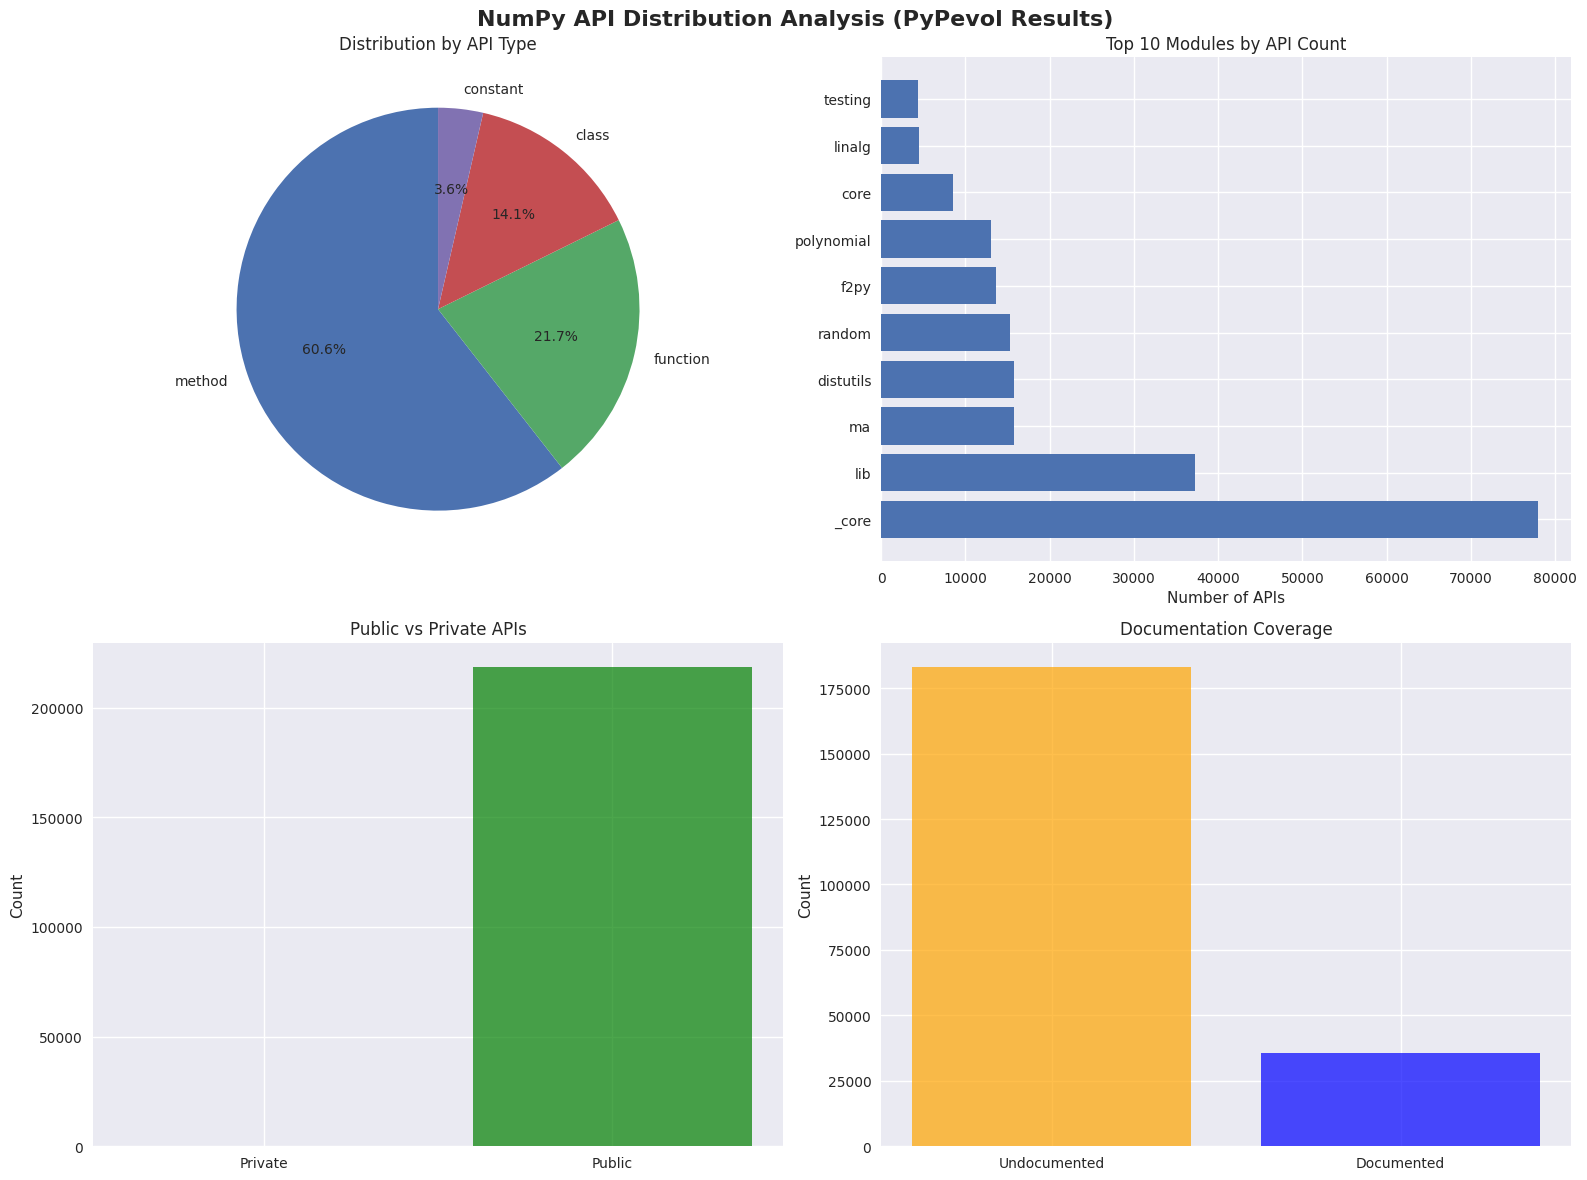

✅ API distribution visualization created


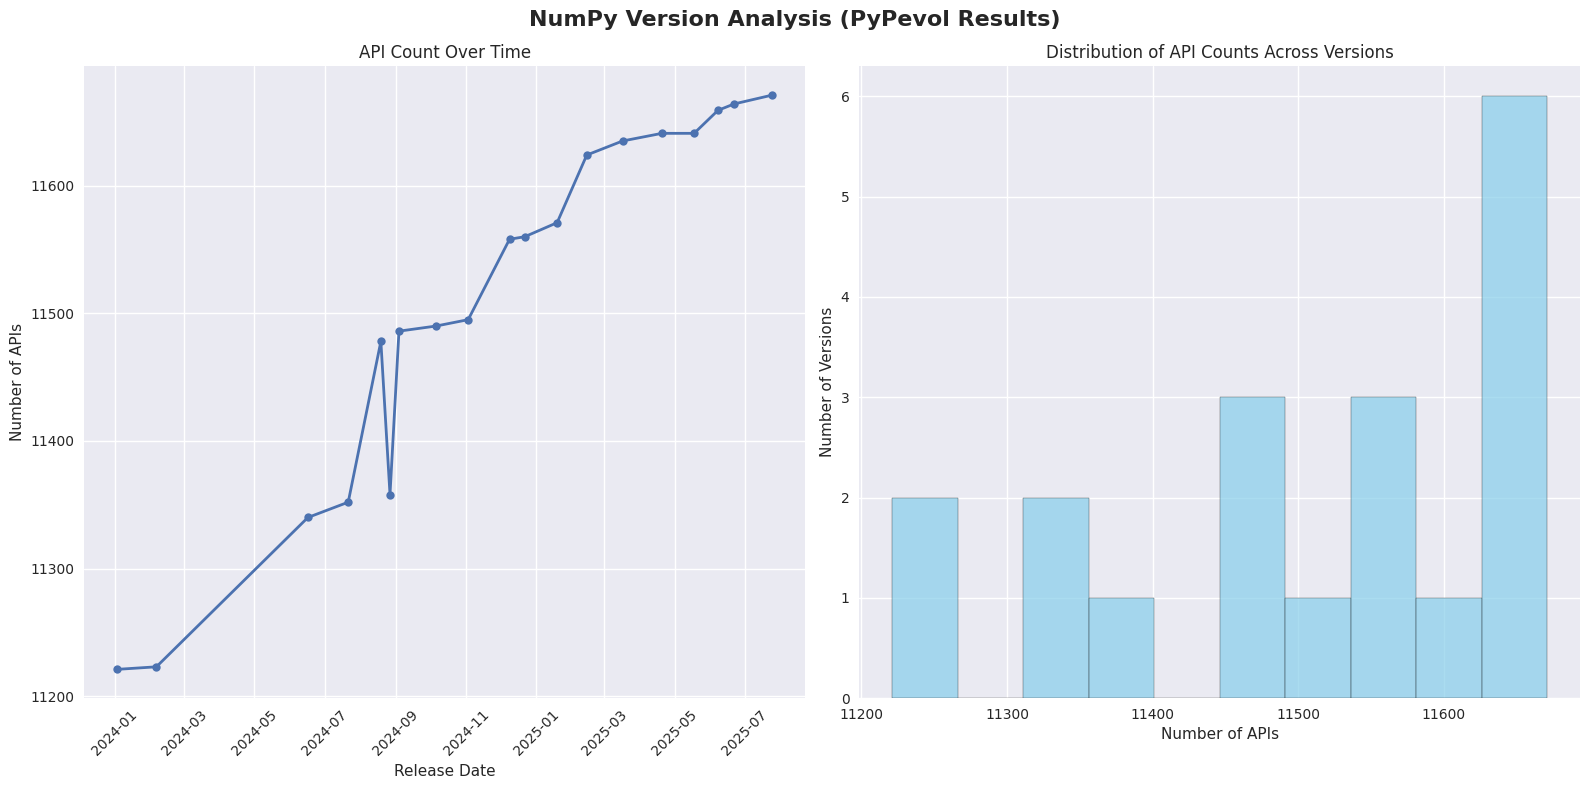

✅ Version analysis visualization created


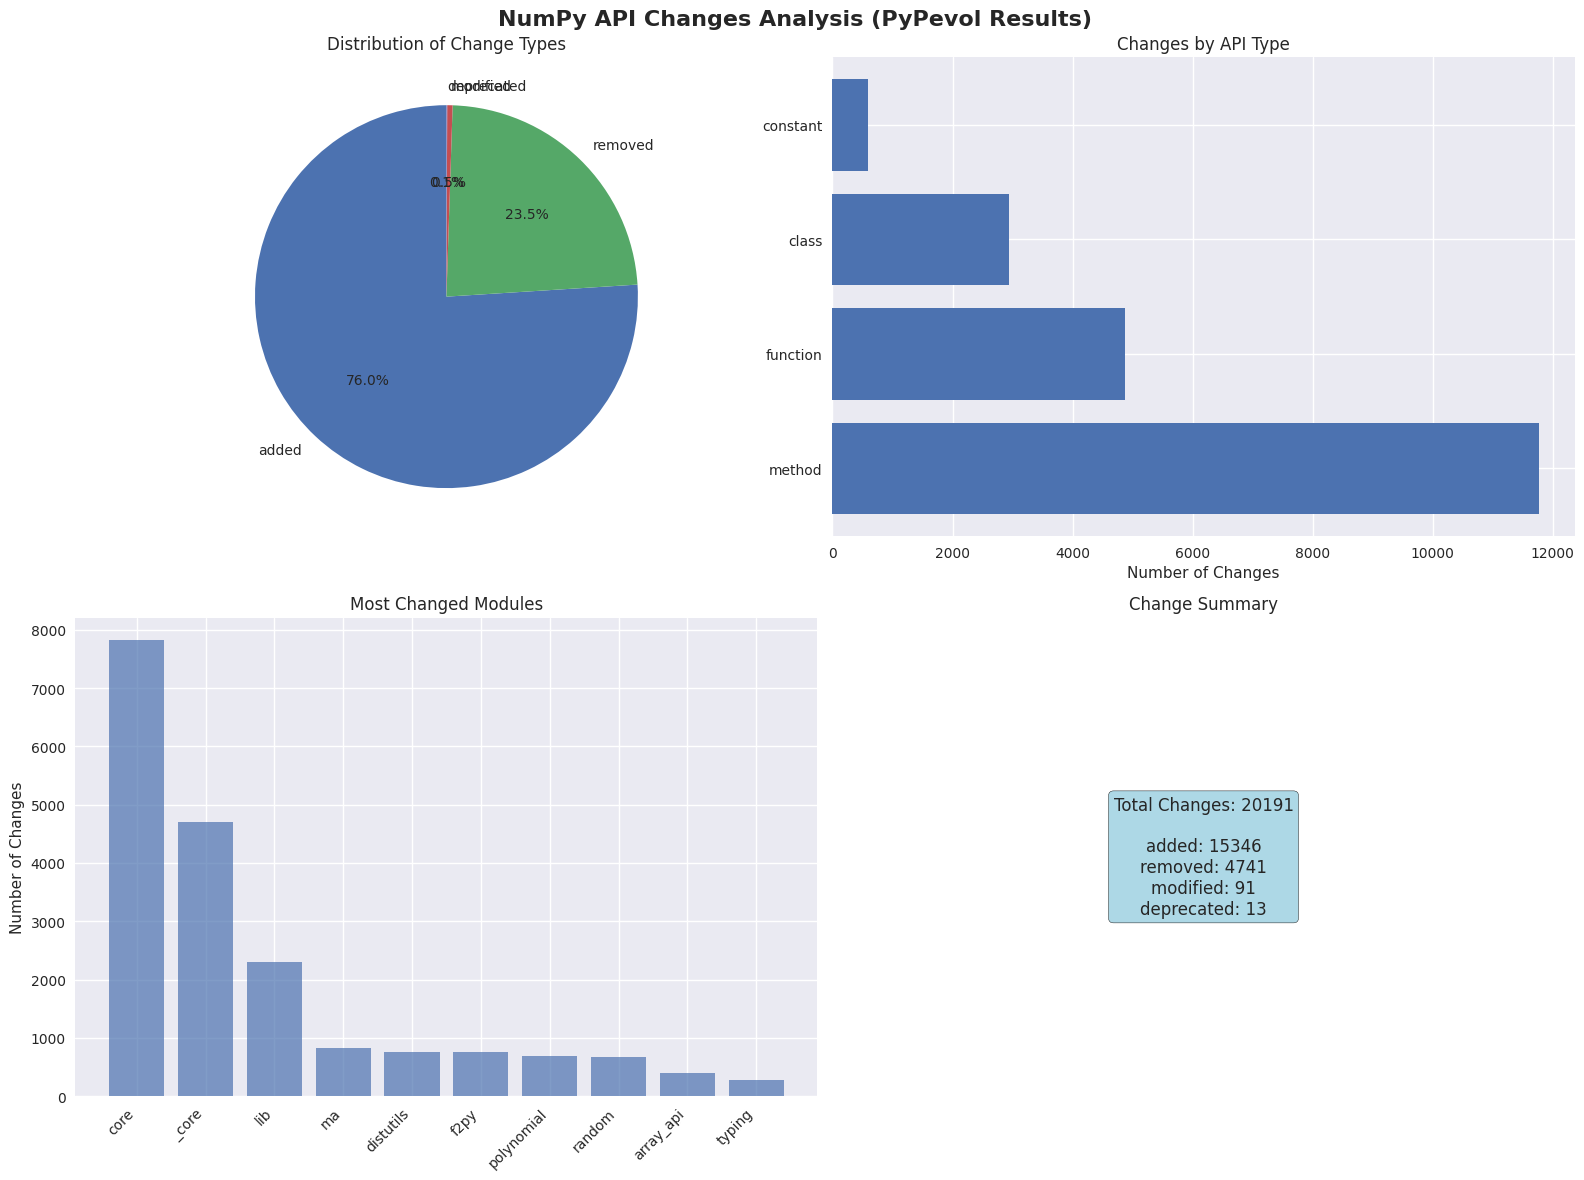

✅ Changes analysis visualization created

🎨 Visualization creation complete!
📊 Visualizations saved to: /home/ec2-user/numpy_analysis/visualizations
📋 Created 3 visualization files:
   🖼️  numpy_api_distribution_20250805_085750.png
   🖼️  numpy_version_analysis_20250805_085750.png
   🖼️  numpy_changes_analysis_20250805_085750.png


In [12]:
# Set up plotting configuration
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.style.use('seaborn-v0_8')

# Create visualization directory
viz_dir = ANALYSIS_DIR / 'visualizations'
viz_dir.mkdir(exist_ok=True)

print("📊 Creating comprehensive visualizations...")

# 1. API Distribution Analysis
if not apis_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NumPy API Distribution Analysis (PyPevol Results)', fontsize=16, fontweight='bold')
    
    # API Types distribution
    type_counts = apis_df['type'].value_counts()
    axes[0, 0].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribution by API Type')
    
    # Top modules
    top_modules = apis_df['top_module'].value_counts().head(10)
    axes[0, 1].barh(range(len(top_modules)), top_modules.values)
    axes[0, 1].set_yticks(range(len(top_modules)))
    axes[0, 1].set_yticklabels(top_modules.index)
    axes[0, 1].set_title('Top 10 Modules by API Count')
    axes[0, 1].set_xlabel('Number of APIs')
    
    # Public vs Private APIs
    public_private = apis_df['is_public'].value_counts()
    labels = ['Private', 'Public']
    values = [public_private.get(False, 0), public_private.get(True, 0)]
    axes[1, 0].bar(labels, values, color=['red', 'green'], alpha=0.7)
    axes[1, 0].set_title('Public vs Private APIs')
    axes[1, 0].set_ylabel('Count')
    
    # Documentation coverage
    doc_coverage = apis_df['has_docstring'].value_counts()
    doc_labels = ['Undocumented', 'Documented']
    doc_values = [doc_coverage.get(False, 0), doc_coverage.get(True, 0)]
    axes[1, 1].bar(doc_labels, doc_values, color=['orange', 'blue'], alpha=0.7)
    axes[1, 1].set_title('Documentation Coverage')
    axes[1, 1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.savefig(viz_dir / f'numpy_api_distribution_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ API distribution visualization created")
else:
    print("⚠️  Skipping API distribution visualization - no API data available")

# 2. Version Analysis
if not versions_df.empty and 'release_date' in versions_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('NumPy Version Analysis (PyPevol Results)', fontsize=16, fontweight='bold')
    
    # API count over time
    versions_sorted = versions_df.sort_values('release_date')
    axes[0].plot(versions_sorted['release_date'], versions_sorted['api_count'], 
                marker='o', linewidth=2, markersize=6)
    axes[0].set_title('API Count Over Time')
    axes[0].set_xlabel('Release Date')
    axes[0].set_ylabel('Number of APIs')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Version distribution
    axes[1].hist(versions_df['api_count'], bins=min(10, len(versions_df)), 
                alpha=0.7, color='skyblue', edgecolor='black')
    axes[1].set_title('Distribution of API Counts Across Versions')
    axes[1].set_xlabel('Number of APIs')
    axes[1].set_ylabel('Number of Versions')
    
    plt.tight_layout()
    plt.savefig(viz_dir / f'numpy_version_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Version analysis visualization created")
else:
    print("⚠️  Skipping version analysis visualization - insufficient version data")

# 3. API Changes Analysis
if not changes_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NumPy API Changes Analysis (PyPevol Results)', fontsize=16, fontweight='bold')
    
    # Change types distribution
    change_counts = changes_df['change_type'].value_counts()
    axes[0, 0].pie(change_counts.values, labels=change_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribution of Change Types')
    
    # Changes by API type
    if 'api_type' in changes_df.columns:
        api_type_changes = changes_df['api_type'].value_counts().head(10)
        axes[0, 1].barh(range(len(api_type_changes)), api_type_changes.values)
        axes[0, 1].set_yticks(range(len(api_type_changes)))
        axes[0, 1].set_yticklabels(api_type_changes.index)
        axes[0, 1].set_title('Changes by API Type')
        axes[0, 1].set_xlabel('Number of Changes')
    
    # Most changed modules
    if 'module_path' in changes_df.columns:
        # Extract top-level module from module path
        changes_df['top_module'] = changes_df['module_path'].str.split('.').apply(
            lambda x: x[1] if len(x) > 1 else x[0]
        )
        module_changes = changes_df['top_module'].value_counts().head(10)
        axes[1, 0].bar(range(len(module_changes)), module_changes.values, alpha=0.7)
        axes[1, 0].set_xticks(range(len(module_changes)))
        axes[1, 0].set_xticklabels(module_changes.index, rotation=45, ha='right')
        axes[1, 0].set_title('Most Changed Modules')
        axes[1, 0].set_ylabel('Number of Changes')
    
    # Change complexity (if available)
    axes[1, 1].text(0.5, 0.5, f'Total Changes: {len(changes_df)}\n\n' + 
                    '\n'.join([f'{k}: {v}' for k, v in change_counts.items()]),
                    ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    axes[1, 1].set_title('Change Summary')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(viz_dir / f'numpy_changes_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Changes analysis visualization created")
else:
    print("⚠️  Skipping changes analysis visualization - no changes data available")

print(f"\n🎨 Visualization creation complete!")
print(f"📊 Visualizations saved to: {viz_dir}")

# List created visualizations
viz_files = list(viz_dir.glob(f'*{timestamp}*.png'))
print(f"📋 Created {len(viz_files)} visualization files:")
for viz_file in viz_files:
    print(f"   🖼️  {viz_file.name}")

📊 Creating advanced analysis visualizations...


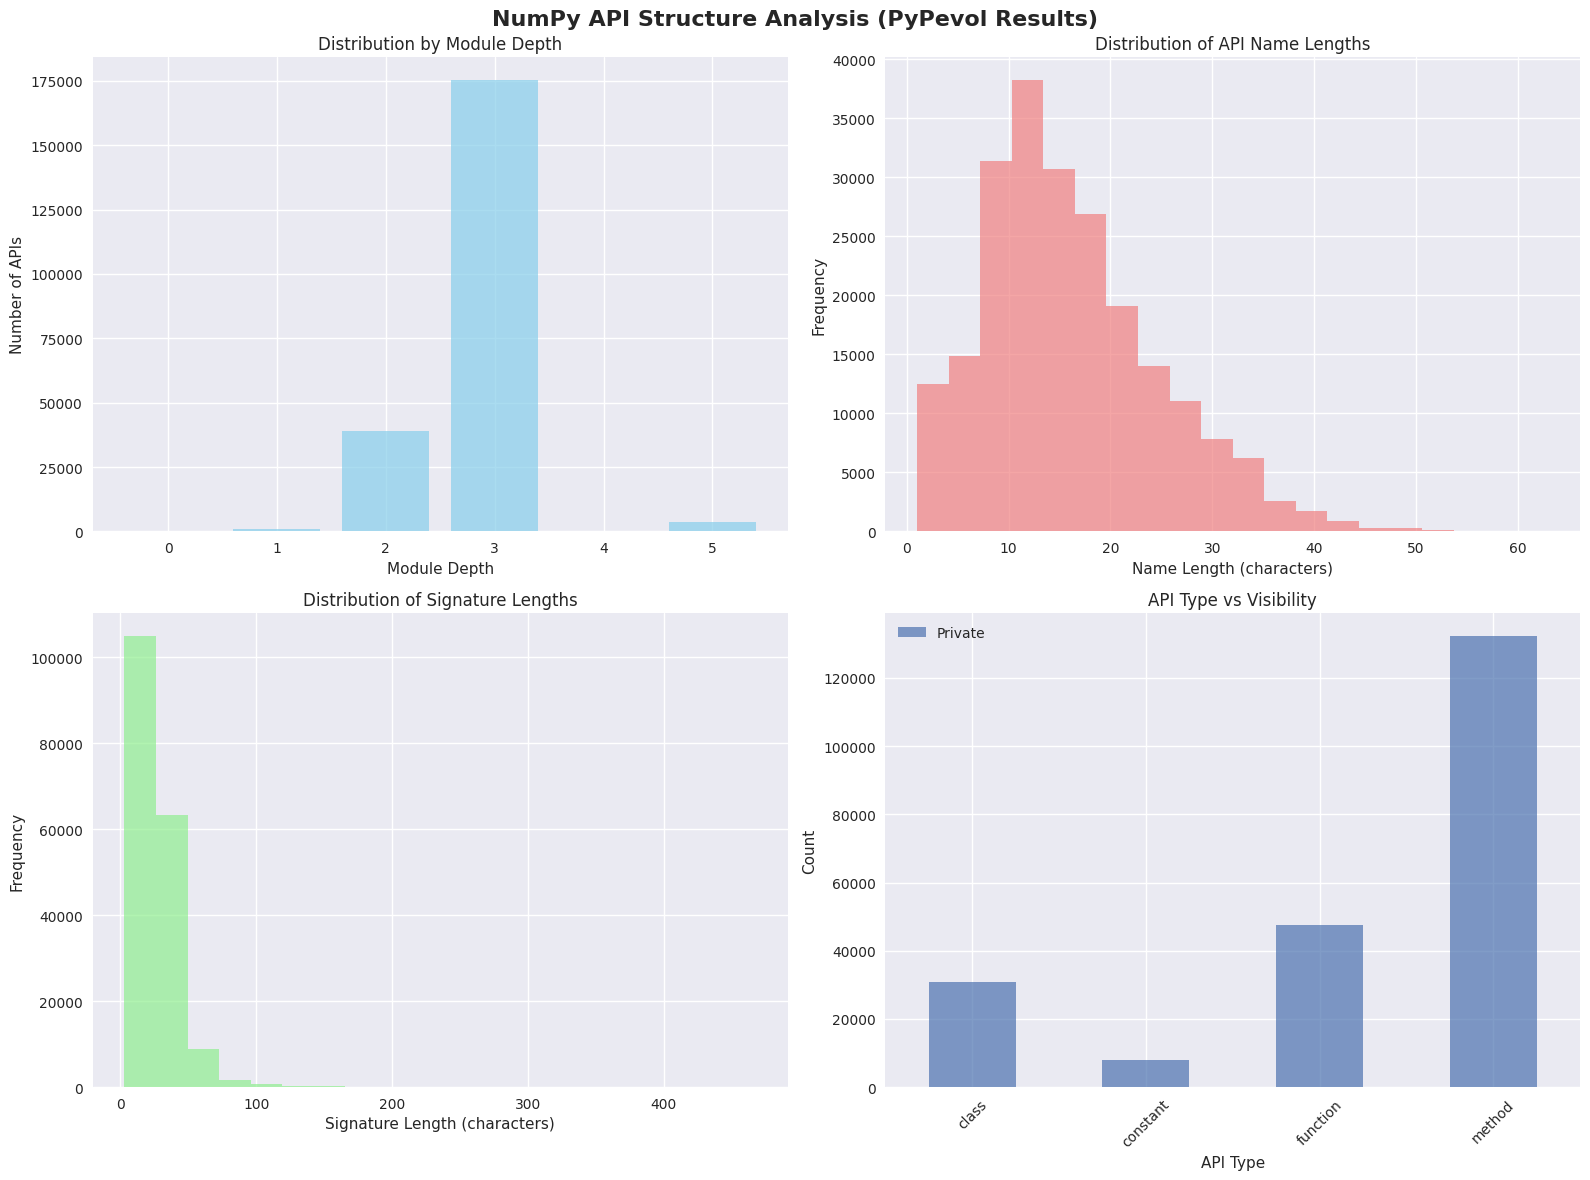

✅ Structure analysis visualization created


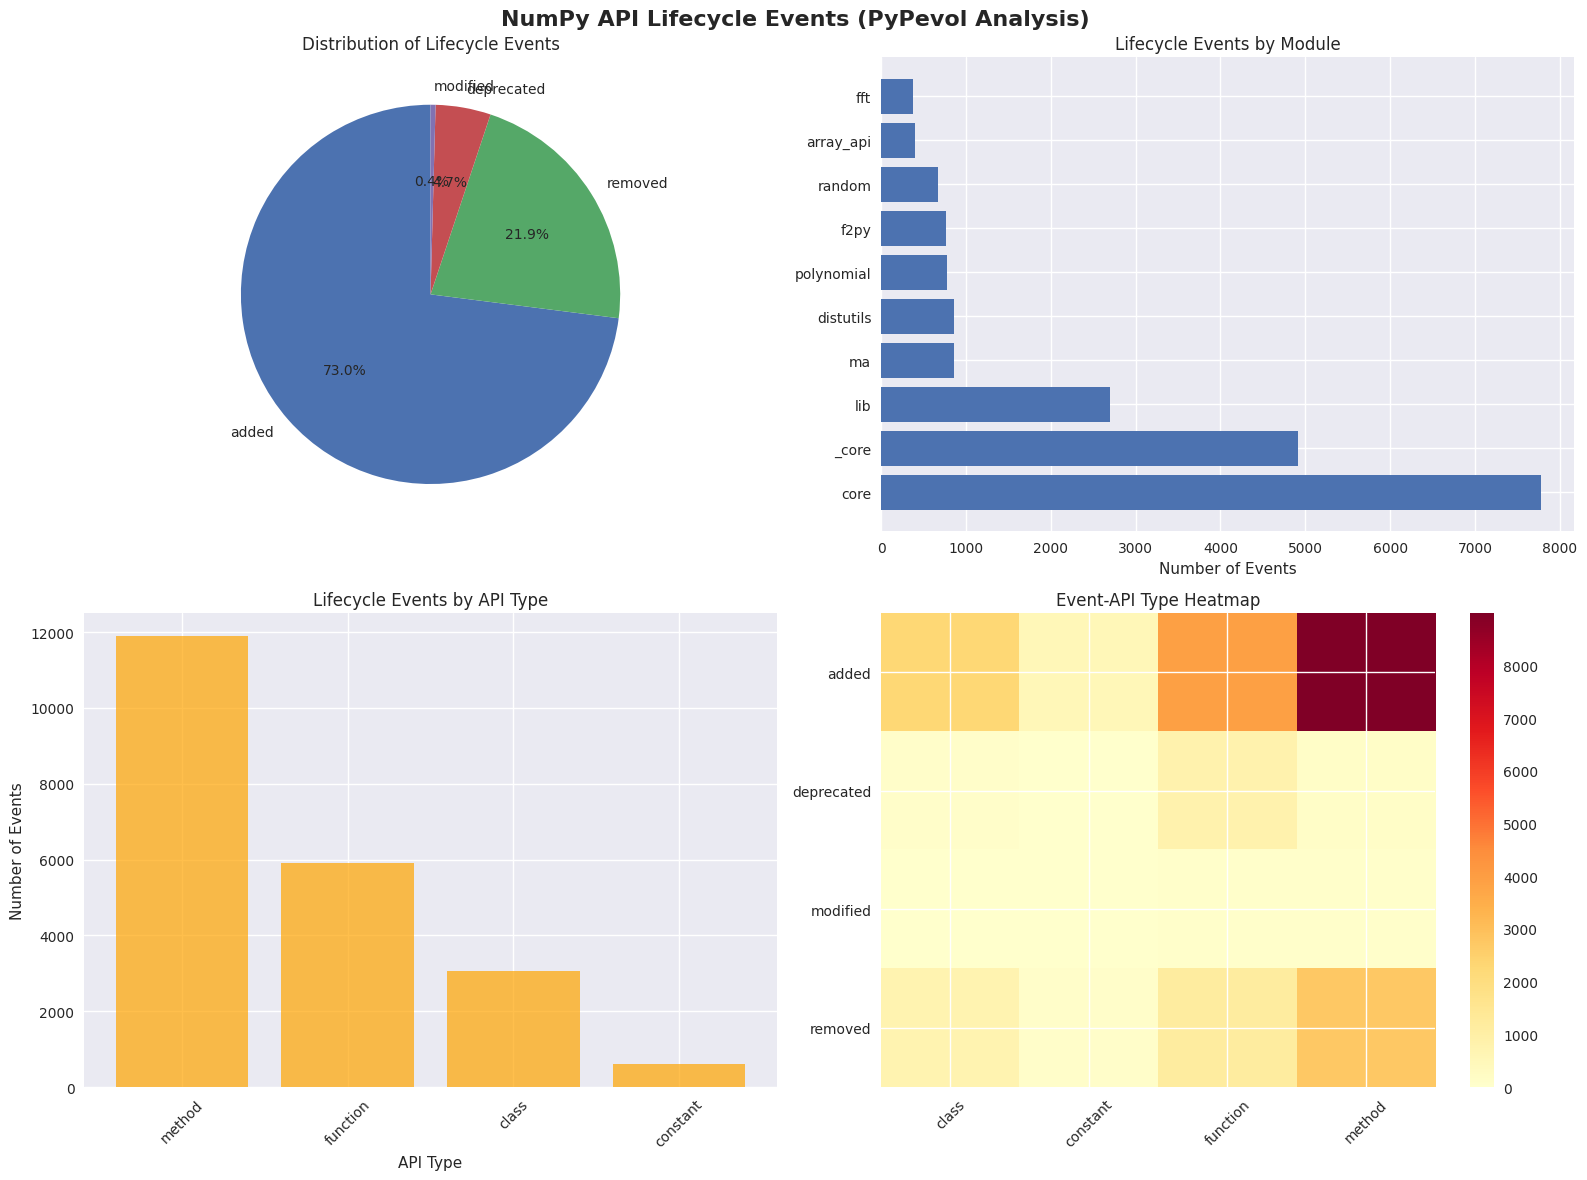

✅ Lifecycle events visualization created


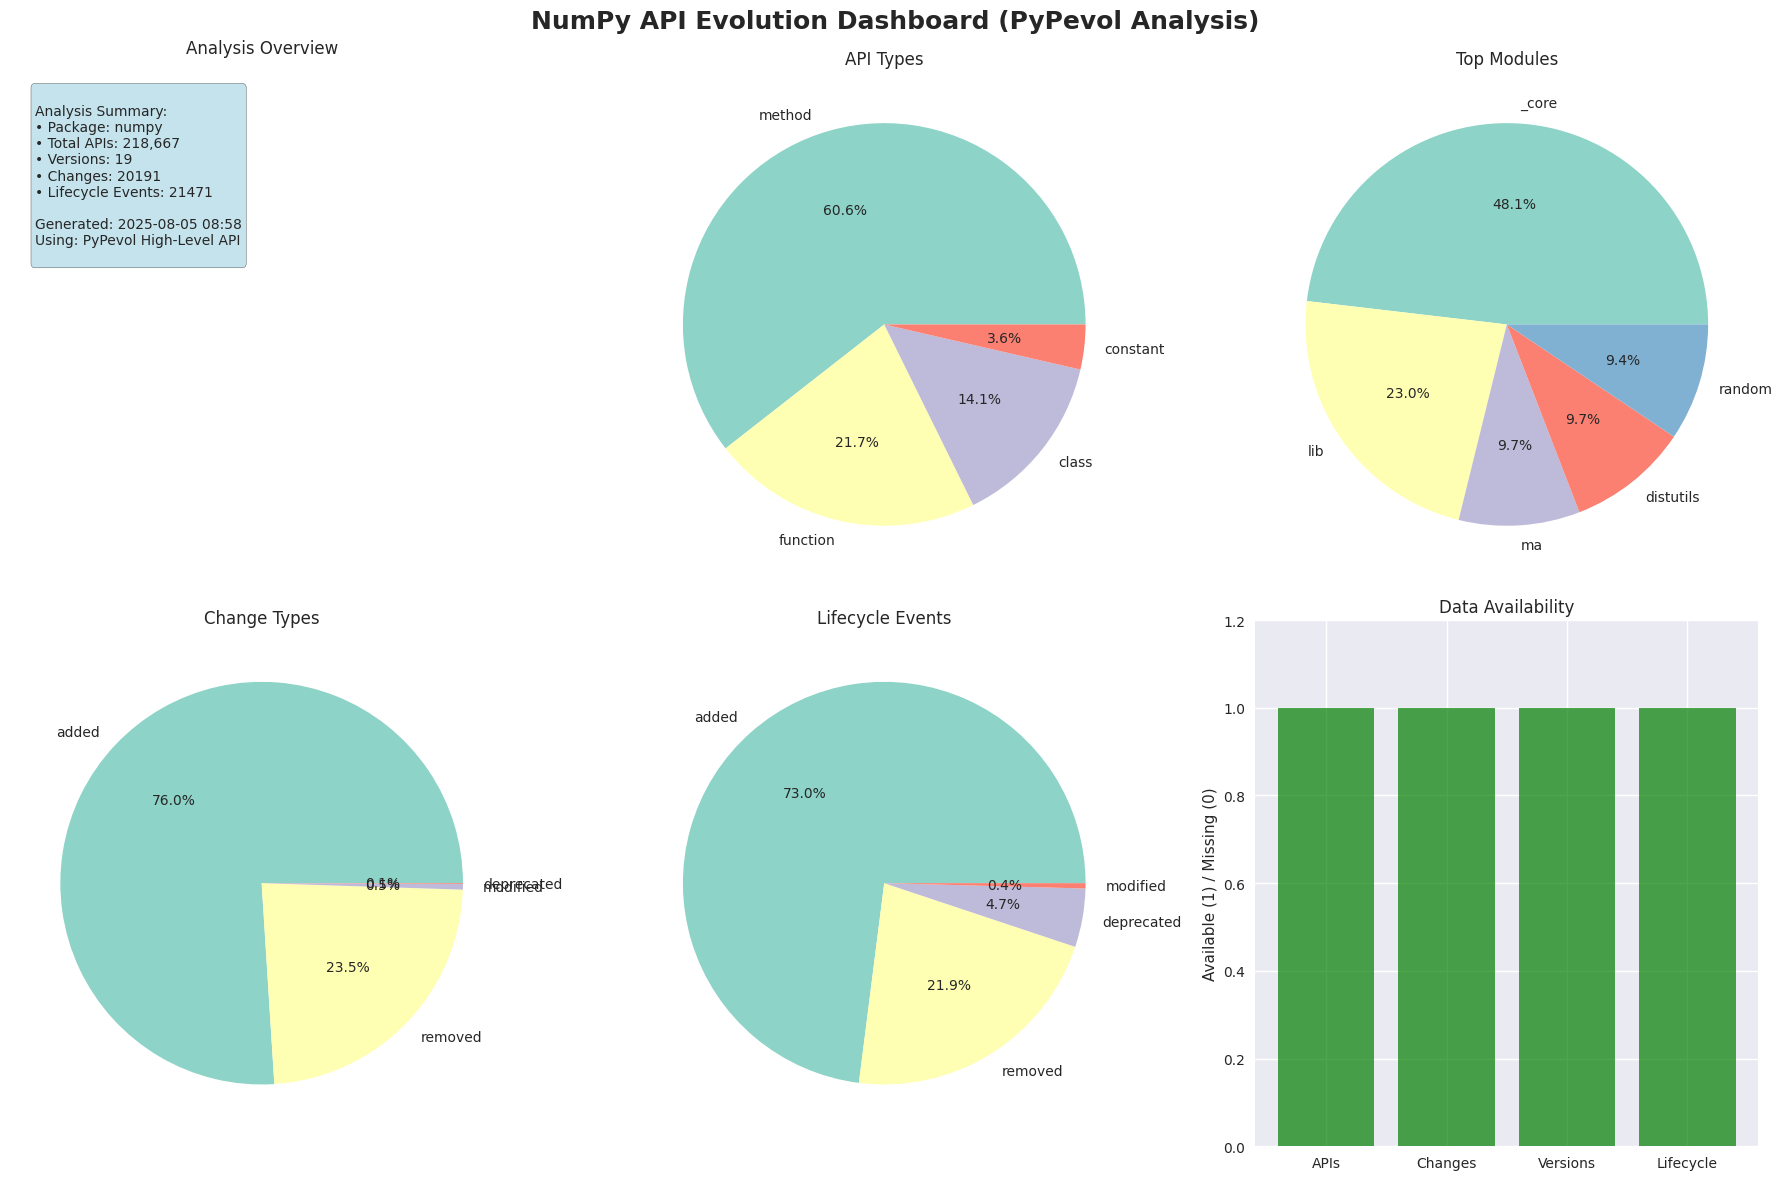

✅ Evolution dashboard created

🎨 All advanced visualizations complete!
📊 Total visualizations created: 6


In [13]:
# 4. Advanced Analysis Visualizations
print("📊 Creating advanced analysis visualizations...")

# Module depth and complexity analysis
if not apis_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NumPy API Structure Analysis (PyPevol Results)', fontsize=16, fontweight='bold')
    
    # Module depth distribution
    if 'module_depth' in apis_df.columns:
        depth_counts = apis_df['module_depth'].value_counts().sort_index()
        axes[0, 0].bar(depth_counts.index, depth_counts.values, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('Distribution by Module Depth')
        axes[0, 0].set_xlabel('Module Depth')
        axes[0, 0].set_ylabel('Number of APIs')
    
    # API name length distribution
    apis_df['name_length'] = apis_df['name'].str.len()
    axes[0, 1].hist(apis_df['name_length'], bins=20, alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('Distribution of API Name Lengths')
    axes[0, 1].set_xlabel('Name Length (characters)')
    axes[0, 1].set_ylabel('Frequency')
    
    # Signature complexity (if available)
    if 'signature' in apis_df.columns:
        sig_lengths = apis_df['signature'].dropna().str.len()
        if not sig_lengths.empty:
            axes[1, 0].hist(sig_lengths, bins=20, alpha=0.7, color='lightgreen')
            axes[1, 0].set_title('Distribution of Signature Lengths')
            axes[1, 0].set_xlabel('Signature Length (characters)')
            axes[1, 0].set_ylabel('Frequency')
        else:
            axes[1, 0].text(0.5, 0.5, 'No signature data available', 
                           ha='center', va='center', fontsize=12)
            axes[1, 0].set_title('Signature Analysis')
    
    # API type vs privacy correlation
    privacy_type_crosstab = pd.crosstab(apis_df['type'], apis_df['is_public'])
    privacy_type_crosstab.plot(kind='bar', ax=axes[1, 1], alpha=0.7)
    axes[1, 1].set_title('API Type vs Visibility')
    axes[1, 1].set_xlabel('API Type')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend(['Private', 'Public'])
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(viz_dir / f'numpy_structure_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Structure analysis visualization created")

# 5. Lifecycle Events Visualization
if not lifecycle_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('NumPy API Lifecycle Events (PyPevol Analysis)', fontsize=16, fontweight='bold')
    
    # Event types distribution
    event_counts = lifecycle_df['event_type'].value_counts()
    axes[0, 0].pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Distribution of Lifecycle Events')
    
    # Events by module
    if 'module' in lifecycle_df.columns:
        # Extract top-level module
        lifecycle_df['top_module'] = lifecycle_df['module'].str.split('.').apply(
            lambda x: x[1] if len(x) > 1 else x[0]
        )
        module_events = lifecycle_df['top_module'].value_counts().head(10)
        axes[0, 1].barh(range(len(module_events)), module_events.values)
        axes[0, 1].set_yticks(range(len(module_events)))
        axes[0, 1].set_yticklabels(module_events.index)
        axes[0, 1].set_title('Lifecycle Events by Module')
        axes[0, 1].set_xlabel('Number of Events')
    
    # Events by API type
    if 'api_type' in lifecycle_df.columns:
        api_type_events = lifecycle_df['api_type'].value_counts()
        axes[1, 0].bar(api_type_events.index, api_type_events.values, alpha=0.7, color='orange')
        axes[1, 0].set_title('Lifecycle Events by API Type')
        axes[1, 0].set_xlabel('API Type')
        axes[1, 0].set_ylabel('Number of Events')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Event type vs API type heatmap
    if 'api_type' in lifecycle_df.columns:
        event_api_crosstab = pd.crosstab(lifecycle_df['event_type'], lifecycle_df['api_type'])
        if not event_api_crosstab.empty:
            im = axes[1, 1].imshow(event_api_crosstab.values, cmap='YlOrRd', aspect='auto')
            axes[1, 1].set_xticks(range(len(event_api_crosstab.columns)))
            axes[1, 1].set_xticklabels(event_api_crosstab.columns, rotation=45)
            axes[1, 1].set_yticks(range(len(event_api_crosstab.index)))
            axes[1, 1].set_yticklabels(event_api_crosstab.index)
            axes[1, 1].set_title('Event-API Type Heatmap')
            plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.savefig(viz_dir / f'numpy_lifecycle_events_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Lifecycle events visualization created")
else:
    print("⚠️  Skipping lifecycle events visualization - no lifecycle data available")

# 6. Summary Dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('NumPy API Evolution Dashboard (PyPevol Analysis)', fontsize=18, fontweight='bold')

# Overall statistics
stats_text = f"""
Analysis Summary:
• Package: {PACKAGE_NAME}
• Total APIs: {len(apis_df) if not apis_df.empty else 0:,}
• Versions: {len(versions_df) if not versions_df.empty else 0}
• Changes: {len(changes_df) if not changes_df.empty else 0}
• Lifecycle Events: {len(lifecycle_df) if not lifecycle_df.empty else 0}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Using: PyPevol High-Level API
"""
axes[0, 0].text(0.05, 0.95, stats_text, transform=axes[0, 0].transAxes, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
axes[0, 0].set_title('Analysis Overview')
axes[0, 0].axis('off')

# Quick charts in remaining subplots
chart_configs = [
    (apis_df, 'type', 'API Types', axes[0, 1]),
    (apis_df, 'top_module', 'Top Modules', axes[0, 2]),
    (changes_df, 'change_type', 'Change Types', axes[1, 0]),
    (lifecycle_df, 'event_type', 'Lifecycle Events', axes[1, 1]),
]

for df, column, title, ax in chart_configs:
    if not df.empty and column in df.columns:
        data = df[column].value_counts().head(5)
        if not data.empty:
            colors = plt.cm.Set3(range(len(data)))
            ax.pie(data.values, labels=data.index, autopct='%1.1f%%', colors=colors)
            ax.set_title(title)
    else:
        ax.text(0.5, 0.5, f'No {title.lower()} data', ha='center', va='center')
        ax.set_title(title)
        ax.axis('off')

# Data quality indicator
quality_scores = {
    'APIs': len(apis_df) > 0,
    'Changes': len(changes_df) > 0,
    'Versions': len(versions_df) > 0,
    'Lifecycle': len(lifecycle_df) > 0
}

quality_labels = list(quality_scores.keys())
quality_values = [1 if v else 0 for v in quality_scores.values()]
quality_colors = ['green' if v else 'red' for v in quality_values]

axes[1, 2].bar(quality_labels, quality_values, color=quality_colors, alpha=0.7)
axes[1, 2].set_title('Data Availability')
axes[1, 2].set_ylabel('Available (1) / Missing (0)')
axes[1, 2].set_ylim(0, 1.2)

plt.tight_layout()
plt.savefig(viz_dir / f'numpy_evolution_dashboard_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Evolution dashboard created")

print(f"\n🎨 All advanced visualizations complete!")
print(f"📊 Total visualizations created: {len(list(viz_dir.glob(f'*{timestamp}*.png')))}")

## 10. Generate Analysis Report

Finally, let's create a comprehensive analysis report summarizing all our findings.

In [14]:
# Generate comprehensive analysis report using PyPevol and custom analysis
print("📋 Generating comprehensive analysis report...")

def create_pypevol_report():
    """Create a report using PyPevol's ReportGenerator and our analysis."""
    
    # Prepare data for PyPevol's report generator
    if analysis_result and hasattr(analysis_result, 'package_name'):
        try:
            # Sample the data for report to avoid memory issues
            # FIXME: Limit the number of changes to speed up
            max_changes_for_report = 1000  # Limit changes for report generation
            sample_changes = analysis_result.changes[:max_changes_for_report] if len(analysis_result.changes) > max_changes_for_report else analysis_result.changes
            
            # Convert to the format expected by PyPevol's report generator
            result_data = {
                'package_name': analysis_result.package_name,
                'summary': {
                    'total_versions': len(analysis_result.versions),
                    'total_apis': sum(len(apis) for apis in analysis_result.api_elements.values()),
                    'total_changes': len(analysis_result.changes),
                    'analysis_date': datetime.now().isoformat()
                },
                'versions': [
                    {
                        'version': v.version,
                        'release_date': v.release_date.isoformat() if v.release_date else None,
                        'api_count': len(analysis_result.api_elements.get(v.version, []))
                    }
                    for v in analysis_result.versions[:20]  # Limit to recent versions for report
                ],
                'changes': [
                    {
                        'api_name': change.element.name if change.element else 'Unknown',
                        'change_type': change.change_type.value,
                        'from_version': change.from_version,
                        'to_version': change.to_version,
                        'description': change.description or ''
                    }
                    for change in sample_changes
                ],
                'metadata': analysis_result.metadata or {}
            }
            
            # Generate reports using PyPevol
            markdown_report = report_generator.generate_single_package_report(result_data, 'markdown')
            
            # Save PyPevol-generated report
            pypevol_report_file = ANALYSIS_DIR / 'reports' / f'pypevol_report_{timestamp}.md'
            with open(pypevol_report_file, 'w') as f:
                f.write(markdown_report)
            
            print(f"✅ PyPevol report generated: {pypevol_report_file}")
            return pypevol_report_file
            
        except Exception as e:
            print(f"⚠️  PyPevol report generation failed: {e}")
            return None
    else:
        print("⚠️  No analysis result available for PyPevol report")
        return None

def create_custom_analysis_report():
    """Create a custom analysis report with our processed data."""
    
    report = []
    report.append("# NumPy API Evolution Analysis Report")
    report.append(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append(f"**Analysis Tool:** PyPevol High-Level API")
    report.append(f"**Package:** {PACKAGE_NAME}")
    report.append("")
    
    # Executive Summary
    report.append("## Executive Summary")
    report.append("")
    
    if not apis_df.empty:
        total_apis = len(apis_df)
        unique_apis = apis_df['full_name'].nunique()
        public_apis = apis_df['is_public'].sum()
        documented_apis = apis_df['has_docstring'].sum()
        
        report.append(f"- **Total API Records:** {total_apis:,}")
        report.append(f"- **Unique APIs:** {unique_apis:,}")
        report.append(f"- **Public APIs:** {public_apis:,} ({public_apis/total_apis*100:.1f}%)")
        report.append(f"- **Documented APIs:** {documented_apis:,} ({documented_apis/total_apis*100:.1f}%)")
        report.append(f"- **Modules Analyzed:** {apis_df['top_module'].nunique():,}")
    
    if not changes_df.empty:
        report.append(f"- **API Changes Detected:** {len(changes_df):,}")
    
    if not versions_df.empty:
        report.append(f"- **Versions Analyzed:** {len(versions_df):,}")
        if 'release_date' in versions_df.columns:
            date_range = versions_df['release_date'].agg(['min', 'max'])
            report.append(f"- **Date Range:** {date_range['min'].strftime('%Y-%m-%d')} to {date_range['max'].strftime('%Y-%m-%d')}")
    
    report.append("")
    
    # Detailed Analysis
    report.append("## Detailed Analysis")
    report.append("")
    
    # API Distribution
    if not apis_df.empty:
        report.append("### API Type Distribution")
        type_counts = apis_df['type'].value_counts()
        for api_type, count in type_counts.items():
            percentage = (count / len(apis_df)) * 100
            report.append(f"- **{api_type}:** {count:,} ({percentage:.1f}%)")
        report.append("")
        
        # Top Modules
        report.append("### Top Modules by API Count")
        top_modules = apis_df['top_module'].value_counts().head(10)
        for i, (module, count) in enumerate(top_modules.items(), 1):
            percentage = (count / len(apis_df)) * 100
            report.append(f"{i}. **{module}:** {count:,} APIs ({percentage:.1f}%)")
        report.append("")
    
    # Changes Analysis
    if not changes_df.empty:
        report.append("### API Changes Analysis")
        change_counts = changes_df['change_type'].value_counts()
        for change_type, count in change_counts.items():
            percentage = (count / len(changes_df)) * 100
            report.append(f"- **{change_type.title()}:** {count:,} ({percentage:.1f}%)")
        report.append("")
        
        # Most changed modules (efficiently)
        if 'module_path' in changes_df.columns:
            # Use vectorized operations instead of apply
            changes_df_copy = changes_df.copy()
            changes_df_copy['top_module'] = changes_df_copy['module_path'].str.split('.').str[1].fillna(changes_df_copy['module_path'].str.split('.').str[0])
            top_changed_modules = changes_df_copy['top_module'].value_counts().head(5)
            report.append("### Most Changed Modules")
            for i, (module, count) in enumerate(top_changed_modules.items(), 1):
                report.append(f"{i}. **{module}:** {count:,} changes")
            report.append("")
    
    # PyPevol Metadata
    if analysis_result and hasattr(analysis_result, 'metadata') and analysis_result.metadata:
        report.append("### PyPevol Analysis Metadata")
        metadata = analysis_result.metadata
        for key, value in metadata.items():
            if isinstance(value, dict):
                report.append(f"- **{key.replace('_', ' ').title()}:**")
                for sub_key, sub_value in value.items():
                    report.append(f"  - {sub_key.replace('_', ' ').title()}: {sub_value}")
            else:
                report.append(f"- **{key.replace('_', ' ').title()}:** {value}")
        report.append("")
    
    # Quality Assessment
    report.append("### Data Quality Assessment")
    available_datasets = sum(1 for df in [apis_df, changes_df, versions_df] if not df.empty)
    report.append(f"- **Analysis Completeness:** {available_datasets}/3 datasets available")
    
    if not apis_df.empty:
        missing_docs = (~apis_df['has_docstring']).sum()
        missing_sigs = apis_df['signature'].isna().sum()
        report.append(f"- **APIs without documentation:** {missing_docs:,} ({missing_docs/len(apis_df)*100:.1f}%)")
        report.append(f"- **APIs without signatures:** {missing_sigs:,} ({missing_sigs/len(apis_df)*100:.1f}%)")
    
    report.append("")
    
    # Methodology
    report.append("## Methodology")
    report.append("This analysis was performed using PyPevol's high-level API, which provides:")
    report.append("- **Automated PyPI Integration:** Fetches package versions directly from PyPI")
    report.append("- **AST-based Parsing:** Uses Python's Abstract Syntax Tree for accurate API extraction")
    report.append("- **Change Detection:** Automatically identifies API changes between versions")
    report.append("- **Comprehensive Analysis:** Tracks functions, classes, methods, and other API elements")
    report.append("")
    
    # Configuration
    report.append("### Analysis Configuration")
    report.append(f"- **Package:** {PACKAGE_NAME}")
    report.append(f"- **Analysis Period:** {from_date.strftime('%Y-%m-%d')} to {to_date.strftime('%Y-%m-%d')}")
    report.append(f"- **Max Versions:** {max_versions}")
    report.append(f"- **Include Private APIs:** {analyzer.parser.include_private}")
    report.append(f"- **Include Deprecated APIs:** {analyzer.parser.include_deprecated}")
    report.append(f"- **Prefer Wheels:** {analyzer.prefer_wheels}")
    report.append("")
    
    # Files Generated
    report.append("## Generated Files")
    report.append("### Data Files")
    data_files = list((ANALYSIS_DIR / 'data').glob(f'*{timestamp}*'))
    for file in data_files:
        report.append(f"- `{file.name}` - {file.stat().st_size / 1024:.1f} KB")
    
    report.append("### Visualizations")
    viz_files = list((ANALYSIS_DIR / 'visualizations').glob(f'*{timestamp}*'))
    for file in viz_files:
        report.append(f"- `{file.name}`")
    
    report.append("")
    report.append("---")
    report.append(f"*Report generated by PyPevol on {datetime.now().strftime('%Y-%m-%d at %H:%M:%S')}*")
    
    return "\n".join(report)

# Generate both reports efficiently
print("📄 Generating reports...")

# Try to generate PyPevol report (with sampling for performance)
pypevol_report_file = create_pypevol_report()

# Generate custom analysis report (optimized)
print("📄 Creating custom analysis report...")
custom_report_content = create_custom_analysis_report()
custom_report_file = ANALYSIS_DIR / 'reports' / f'custom_analysis_report_{timestamp}.md'
with open(custom_report_file, 'w') as f:
    f.write(custom_report_content)

print(f"✅ Custom analysis report saved: {custom_report_file}")

# Generate JSON report for programmatic access (efficiently)
print("📄 Creating JSON summary...")
json_report = {
    'analysis_info': {
        'package': PACKAGE_NAME,
        'timestamp': datetime.now().isoformat(),
        'tool': 'PyPevol High-Level API',
        'analysis_period': f"{from_date.strftime('%Y-%m-%d')} to {to_date.strftime('%Y-%m-%d')}"
    },
    'summary_statistics': {
        'total_apis': len(apis_df) if not apis_df.empty else 0,
        'total_changes': len(changes_df) if not changes_df.empty else 0,
        'total_versions': len(versions_df) if not versions_df.empty else 0,
        'total_lifecycle_events': len(lifecycle_df) if not lifecycle_df.empty else 0
    },
    'data_files': [f.name for f in (ANALYSIS_DIR / 'data').glob(f'*{timestamp}*')],
    'visualization_files': [f.name for f in (ANALYSIS_DIR / 'visualizations').glob(f'*{timestamp}*')],
    'report_files': [f.name for f in (ANALYSIS_DIR / 'reports').glob(f'*{timestamp}*')]
}

json_report_file = ANALYSIS_DIR / 'reports' / f'analysis_summary_{timestamp}.json'
with open(json_report_file, 'w') as f:
    import json
    json.dump(json_report, f, indent=2, default=str)

print(f"✅ JSON summary report saved: {json_report_file}")

print("\n" + "="*80)
print("NUMPY API EVOLUTION ANALYSIS COMPLETE")
print("="*80)

# Final summary (efficiently calculated)
print("📊 Final Results Summary:")
if not apis_df.empty:
    total_apis = len(apis_df)
    unique_versions = apis_df['version'].nunique()
    public_apis = apis_df['is_public'].sum()
    documented_apis = apis_df['has_docstring'].sum()
    
    print(f" APIs Analyzed: {total_apis:,} (across {unique_versions} versions)")
    print(f"🔓 Public APIs: {public_apis:,} ({public_apis/total_apis*100:.1f}%)")
    print(f"📚 Documented APIs: {documented_apis:,} ({documented_apis/total_apis*100:.1f}%)")

if not changes_df.empty:
    print(f"🔄 Changes Detected: {len(changes_df):,}")

if not versions_df.empty:
    print(f"📦 Versions Analyzed: {len(versions_df):,}")

print(f"\n📁 All files saved in: {ANALYSIS_DIR}")
print(f"📋 Reports available:")
if pypevol_report_file:
    print(f"   • PyPevol Report: {pypevol_report_file.name}")
print(f"   • Custom Report: {custom_report_file.name}")
print(f"   • JSON Summary: {json_report_file.name}")

print("\n🎉 Analysis complete! Ready for further exploration and insights.")
print("="*80)

📋 Generating comprehensive analysis report...
📄 Generating reports...
⚠️  PyPevol report generation failed: 'changes_by_type'
📄 Creating custom analysis report...
✅ Custom analysis report saved: /home/ec2-user/numpy_analysis/reports/custom_analysis_report_20250805_085750.md
📄 Creating JSON summary...
✅ JSON summary report saved: /home/ec2-user/numpy_analysis/reports/analysis_summary_20250805_085750.json

NUMPY API EVOLUTION ANALYSIS COMPLETE
📊 Final Results Summary:
 APIs Analyzed: 218,667 (across 19 versions)
🔓 Public APIs: 218,667 (100.0%)
📚 Documented APIs: 35,442 (16.2%)
🔄 Changes Detected: 20,191
📦 Versions Analyzed: 19

📁 All files saved in: /home/ec2-user/numpy_analysis
📋 Reports available:
   • Custom Report: custom_analysis_report_20250805_085750.md
   • JSON Summary: analysis_summary_20250805_085750.json

🎉 Analysis complete! Ready for further exploration and insights.


## 🚀 Execution Instructions - PyPevol High-Level API

This notebook leverages **PyPevol's high-level APIs** for comprehensive NumPy API evolution analysis. The analysis is fully automated and requires minimal manual intervention.

### 📁 Expected Output Structure:
```
numpy_analysis/
├── data/
│   ├── pypevol_analysis_result_TIMESTAMP.json    # Raw PyPevol results
│   ├── numpy_apis_TIMESTAMP.csv                  # Processed API data
│   ├── numpy_changes_TIMESTAMP.csv               # API changes
│   ├── numpy_versions_TIMESTAMP.csv              # Version info
│   └── analysis_summary_TIMESTAMP.json           # Summary statistics
├── visualizations/
│   ├── numpy_api_distribution_TIMESTAMP.png      # API type distributions
│   ├── numpy_version_analysis_TIMESTAMP.png      # Version trends
│   ├── numpy_changes_analysis_TIMESTAMP.png      # Change patterns
│   └── numpy_evolution_dashboard_TIMESTAMP.png   # Comprehensive dashboard
└── reports/
    ├── pypevol_report_TIMESTAMP.md               # PyPevol-generated report
    ├── custom_analysis_report_TIMESTAMP.md       # Custom analysis report
    └── analysis_summary_TIMESTAMP.json           # Machine-readable summary
```
